In [1]:
import statsmodels.api as sm
 
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_datab

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [6]:
import pandas as pd
import numpy as np

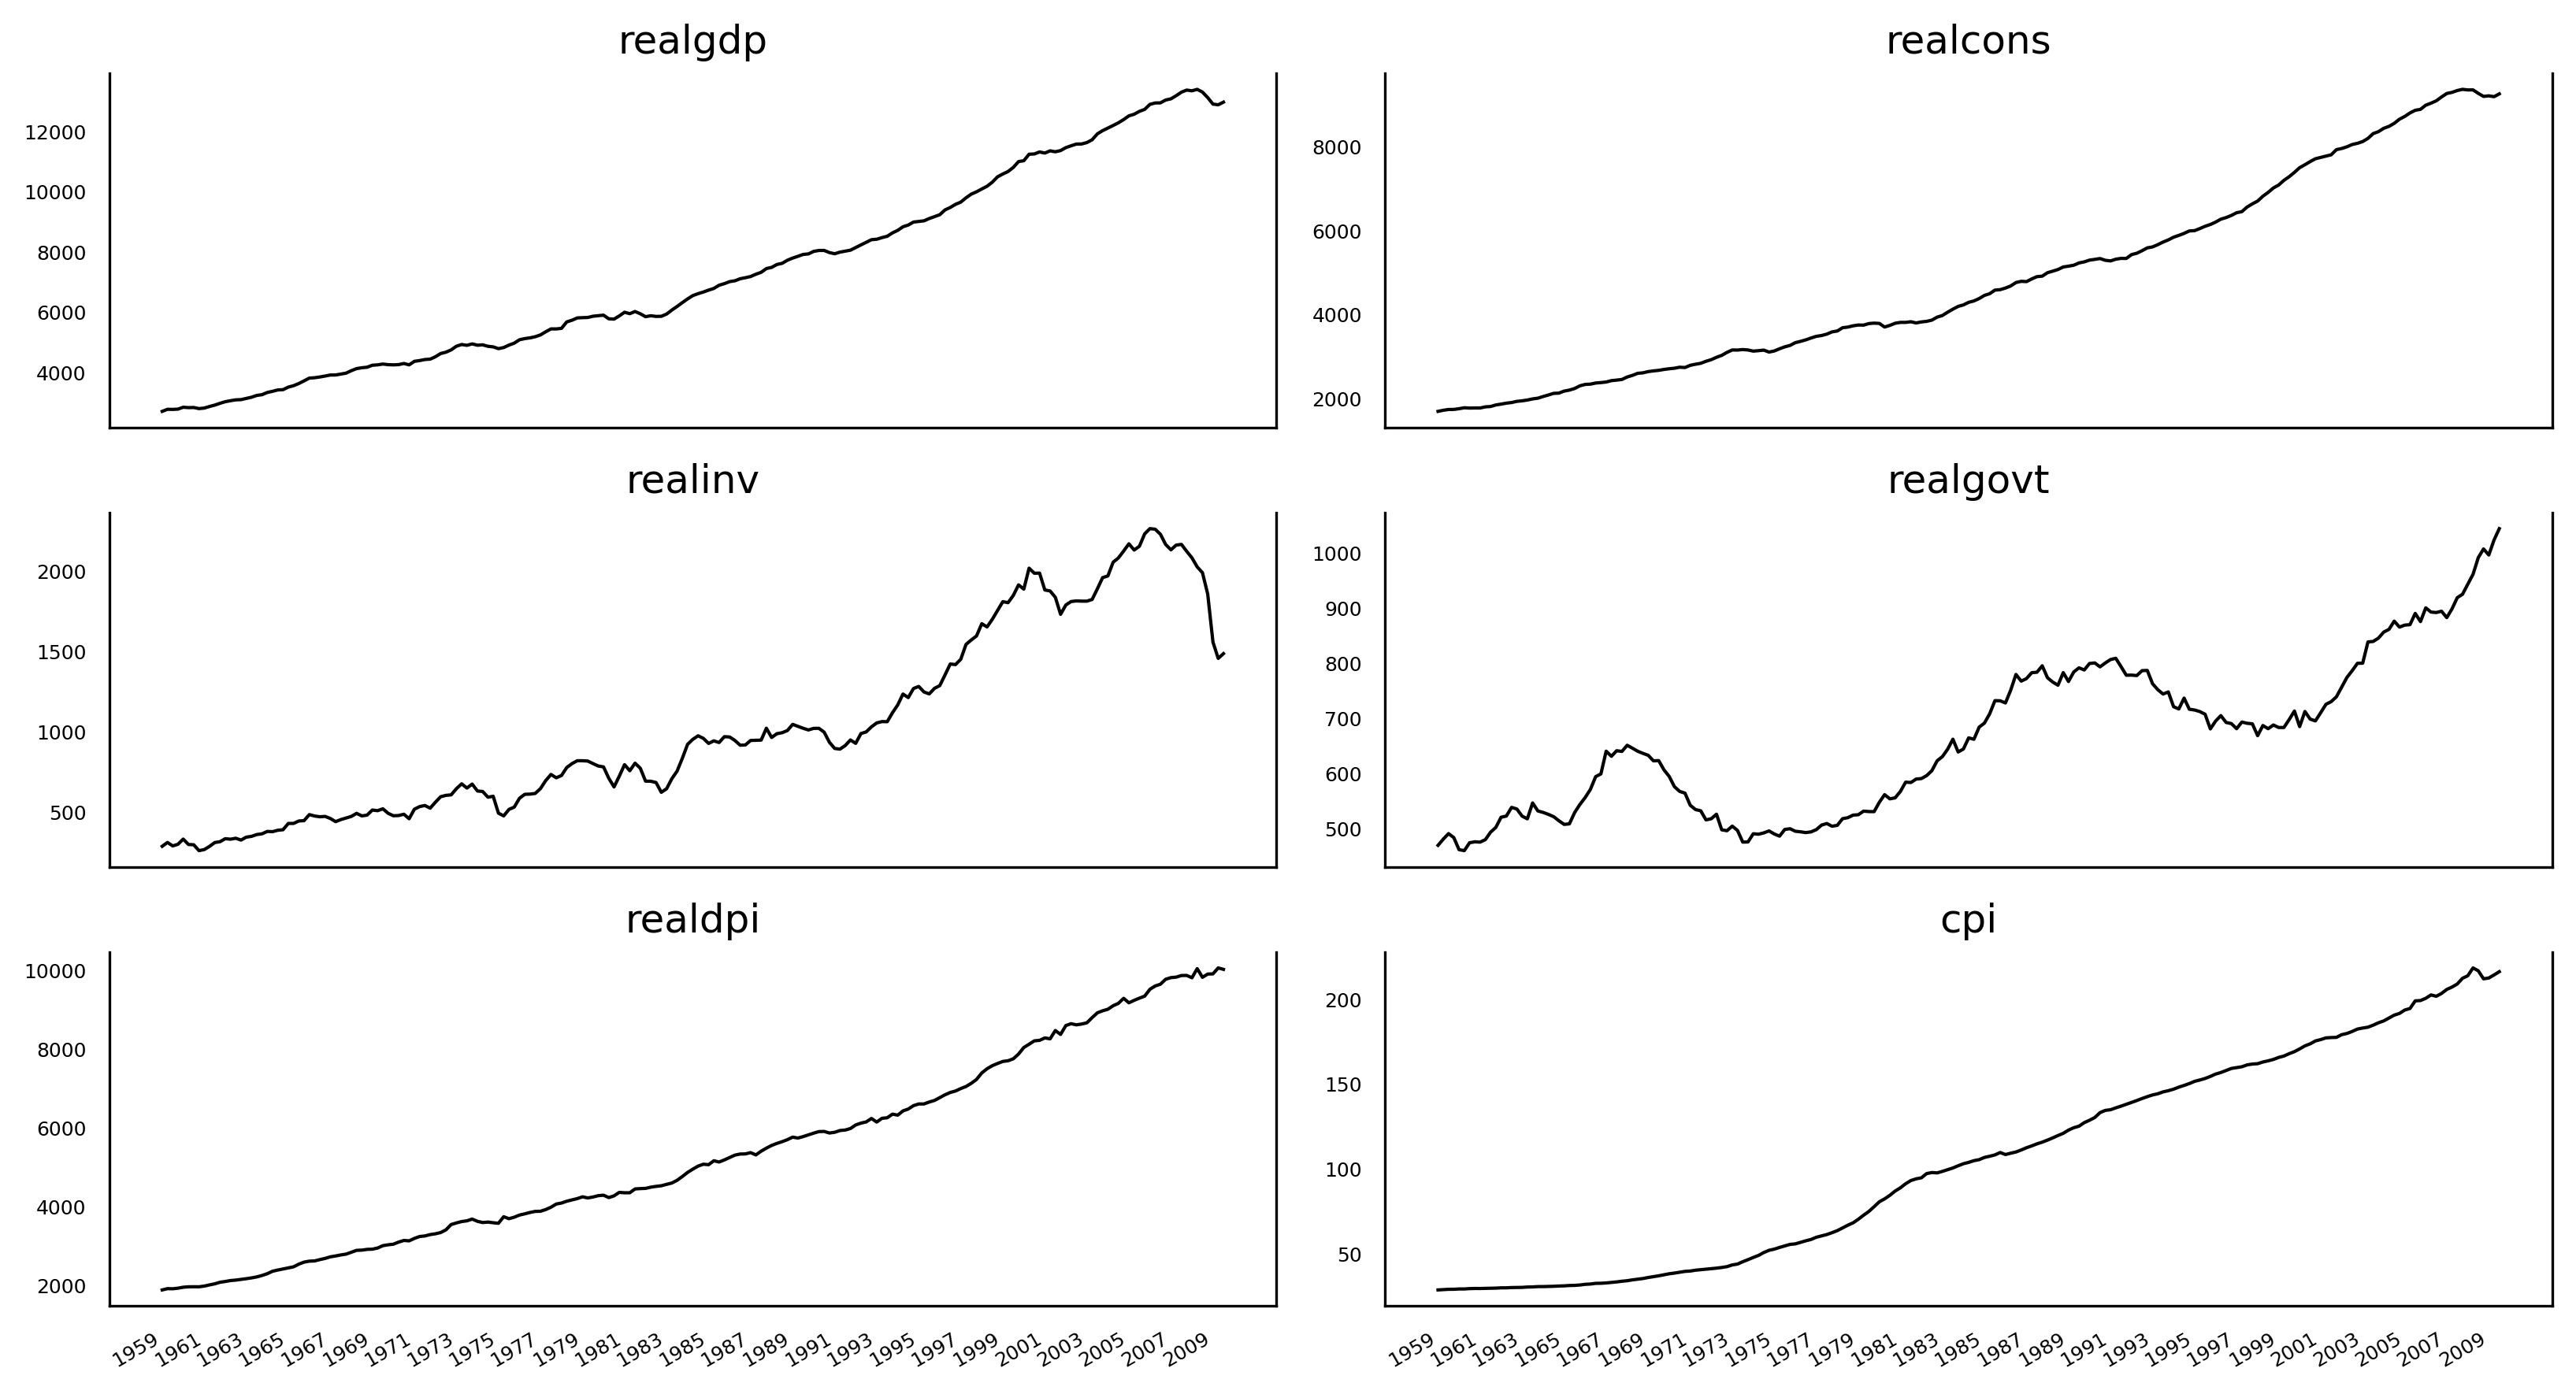

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))
 
for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
 
plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [10]:
from statsmodels.tsa.stattools import adfuller

target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]
 
ad_fuller_result = adfuller(target)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647166
p-value: 0.9982455372335032


In [11]:
target_diff = target.diff()
 
ad_fuller_result = adfuller(target_diff[1:])
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [15]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
def optimize_SARIMAX(endog: Union[pd.Series, list] , exog: Union[pd.Series, list], order_list: list, d: int, D: int,  s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [19]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4
 
from itertools import product
parameters = product(p, q, P, Q)
parameters_list = list(parameters) 

In [21]:
target_train = target[:200]
exog_train = exog[:200]
 
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

<ipython-input-17-b161305fb58e>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

,"(p,q,P,Q)",AIC
0,"(2, 2, 0, 0)",1742.792051
1,"(3, 3, 0, 0)",1742.859832
2,"(3, 3, 0, 1)",1744.971949
3,"(3, 3, 1, 0)",1744.974837
4,"(2, 2, 0, 1)",1745.175036
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


In [23]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
 
print(best_model_fit.summary())
#A Display the summary table of the model

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.430
Date:                Fri, 23 Sep 2022   AIC                           1742.860
Time:                        15:08:19   BIC                           1782.379
Sample:                             0   HQIC                          1758.854
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9651      0.044     21.903      0.000       0.879       1.051
realinv        1.0180      0.032     31.681      0.000       0.955       1.081
realgovt       0.7344      0.125      5.885      0.0

C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


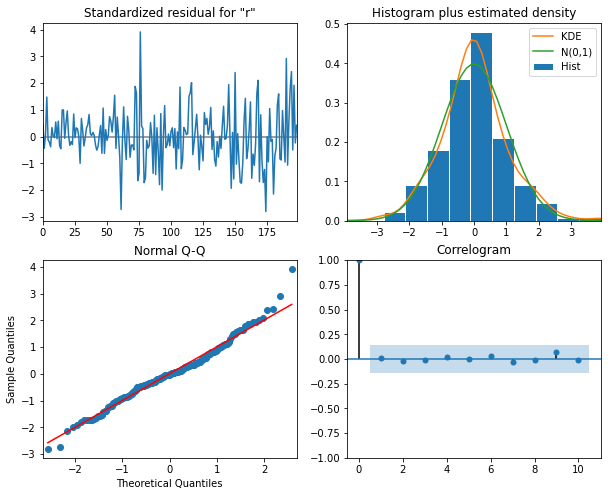

In [24]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [35]:
def recursive_forecast(endog: Union[pd.Series, list],  exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
 
    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX
            
    elif method=='SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model_a = SARIMAX(endog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res_a = model_a.fit(disp=False)
            oos_pred = res_a.predict(-window)
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [36]:
target_train = target[:196]
target_test = target[196:]
 
pred_df = pd.DataFrame({'actual': target_test})
 
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1
 
pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA= recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
 
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMA'] = pred_SARIMA
pred_df['pred_SARIMAX'] = pred_SARIMAX
 
pred_df

C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\base\model

,actual,pred_last_value,pred_SARIMA,pred_SARIMAX
196,13366.865,13391.249,13426.290935,13344.043336
197,13415.266,13366.865,13465.101838,13373.483928
198,13324.600,13415.266,13433.442550,13378.658044
199,13141.920,13324.600,13455.445680,13325.954913
200,12925.410,13141.920,13298.706540,13134.220627
201,12901.504,12925.410,13062.383123,12887.516596
202,12990.341,12901.504,12803.786837,12873.822211


In [40]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMA=mape(pred_df.actual, pred_df.pred_SARIMA)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

In [44]:
mape_last, mape_SARIMA, mape_SARIMAX

(0.736849498653785, 1.3699670943081796, 0.7013054114487612)